In [1]:
import torch
import torch.nn as nn
import torchvision as tv
import pandas as pd
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn.functional as Func


In [2]:
logostxt=open("D:/Downloads/datasets/mini_logo_good/spisok.txt")
logos_list=logostxt.read().split("\n")
#logos_list=['Burger King','KFC','McDonalds','Other','Starbucks','Subway']
logos_list.sort()
CountOfClasses=len(logos_list)
logos_list

['ABLE',
 'AC',
 'ACID',
 'AFernandez',
 'ALCO',
 'AND1',
 'Acorn',
 'AdanyEva',
 'Addidas',
 'Advent',
 'Alliance',
 'AlmostSkateboards',
 'Always',
 'Amador',
 'Amoco',
 'Amsterdam',
 'Anchorage',
 'Animal',
 'Ankara',
 'Annapurna']

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('device is',device)

device is cpu


In [4]:
path = 'D:/Downloads/datasets/mini_logo_good/train'

In [5]:
transforms=tv.transforms.Compose([
    tv.transforms.Resize((70,70)),
    tv.transforms.ToTensor()
    
])

In [6]:
from matplotlib.transforms import Transform
dataset=tv.datasets.ImageFolder(root=path,transform=transforms)

In [7]:
dataloader=torch.utils.data.DataLoader(dataset,batch_size=16,shuffle=True,num_workers=4)

(tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.5608, 0.5608, 0.5608,  ..., 0.5608, 0.5608, 0.5608],
         [0.5608, 0.5608, 0.5608,  ..., 0.5608, 0.5608, 0.5608],
         [0.5608, 0.5608, 0.5608,  ..., 0.5608, 0.5608, 0.5608]],

        [[0.1529, 0.1529, 0.1529,  ..., 0.1529, 0.1529, 0.1529],
         [0.1529, 0.1529, 0.1529,  ..., 0.1529, 0.1529, 0.1529],
         [0.1529, 0.1529, 0.1529,  ..., 0.1529, 0.1529, 0.1529],
         ...,
         [0.5608, 0.5608, 0.5608,  ..., 0.5608, 0.5608, 0.5608],
         [0.5608, 0.5608, 0.5608,  ..., 0.5608, 0.5608, 0.5608],
         [0.5608, 0.5608, 0.5608,  ..., 0.5608, 0.5608, 0.5608]],

        [[0.1725, 0.1725, 0.1725,  ..., 0.1725, 0.1725, 0.1725],
         [0.1725, 0.1725, 0.1725,  ..., 0.1725, 0.1725, 0.1725],
         [0.1725, 0.1725, 0.1725,  ..., 0.1725, 0.1725, 0

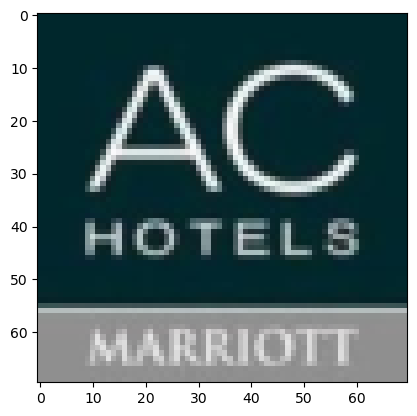

In [8]:
plt.imshow(dataset[118][0].numpy().transpose((1,2,0)))
print(dataset[118])
#print(dataset[50][0].numpy().transpose((1,2,0)).shape)
#print(dataset[50][0].shape)
#m=nn.Conv2d(3,32,kernel_size=3,padding=0)
#m=nn.AdaptiveAvgPool2d((1,1))
#print(m(dataset[50][0]).shape) 
#plt.imshow(m(dataset[50][0]).numpy().transpose((1,2,0)))
#print(dataset[50])

In [9]:
class CNA(nn.Module):
  def __init__(self,in_ch=32,out_ch=32):
    super().__init__()
    self.conv=nn.Conv2d(in_ch,out_ch,kernel_size=3,padding=1)
    self.norm=nn.BatchNorm2d(out_ch)
    self.act=nn.ReLU()

  def forward(self,x):
    out=self.conv(x)
    out=self.norm(out)
    out=self.act(out)
    return out
net=CNA()
net=net.to(device)

In [10]:
class MyConvModel(nn.Module):
  def __init__(self, base_ch=64):
    super().__init__()
    cna1_1=CNA(3,base_ch) 
    cna1_2=CNA(base_ch,base_ch) 
    cna2_1=CNA(base_ch,2*base_ch)
    cna2_2=CNA(2*base_ch,2*base_ch)
    cna3_1=CNA(2*base_ch,4*base_ch)
    cna3_2=CNA(4*base_ch,4*base_ch)
    cna4_1=CNA(4*base_ch,8*base_ch)
    cna4_2=CNA(8*base_ch,8*base_ch)
    cna5_1=CNA(8*base_ch,16*base_ch)
    cna6_1=CNA(16*base_ch,32*base_ch)
    
    Linear=nn.Linear(32*base_ch,CountOfClasses)
    maxpool=nn.MaxPool2d(2,2)
    avgpool=nn.AdaptiveAvgPool2d((1,1))
    flatten=nn.Flatten()
    self.model = nn.Sequential(
          cna1_1,cna1_2,maxpool,# (16,3,60,60)-> (16,32,30,30)
          cna2_1,cna2_2,maxpool,#(16,32,30,30)->(16,64,15,15)
          cna3_1,cna3_2,maxpool,
          cna4_1,cna4_2,maxpool,
          cna5_1,maxpool,
          cna6_1,avgpool,
          flatten,Linear
    )
  def forward(self,x):
    return self.model(x)
net=MyConvModel()
net=net.to(device)

In [11]:
#loss_fn = nn.CrossEntropyLoss()
loss_fn=nn.MSELoss()
optimizer=torch.optim.Adam(net.parameters(),lr=1e-4, betas=(0.9, 0.999))
def count_parameters(net):
    return sum(p.numel() for p in net.parameters() if p.requires_grad)
print(count_parameters(net))

28332372


In [12]:
def get_accuracy(pred, label):
    answer = pred.detach().numpy().argmax(1) == label.numpy().argmax(1) 
    return answer.mean()

AxisError: axis 1 is out of bounds for array of dimension 1

In [13]:
epochs=10
for epoch in range(epochs):
    loss_val=0
    acc_val=0

    for sample in dataloader:
        img,label = sample

        label = label.to(device)
        label = Func.one_hot(label, num_classes=CountOfClasses).float()
        # label=Func.one_hot(label,num_classes=10)
        #label = label.float()
        #label = label.unsqueeze(1)
        img = img.to(device)
        
        optimizer.zero_grad()
       
        
        pred = net (img)

        loss = loss_fn(pred, label)
        loss.backward()

        optimizer.step()
        
        loss_val+=loss.item()
        acc_val += get_accuracy(pred.cpu(), label.cpu())

    loss_val /= len(dataloader)
    acc_val /= len(dataloader)
    print("epoch=",epoch,"loss=",loss_val ,"accruracy=",acc_val)

KeyboardInterrupt: 

In [ ]:
torch.save(net, 'D:\\myprogect\\pytorch\\weightsOfLogoClassifierbatch1')

In [ ]:
#net = MyConvModel()
net = torch.load('D:\\myprogect\\pytorch\\weightsOfLogoClassifierbatch1')
#net.eval()

Test for one image

tensor([[-0.0202, -0.0473,  0.0557,  0.0305,  0.1049,  0.0324,  0.0480,  0.0511,
          0.0960,  0.0794,  0.1182,  0.0489,  0.0295,  0.0148,  0.0411, -0.0009,
          0.0838,  0.0133,  0.0506,  0.0352]], grad_fn=<AddmmBackward0>)
[-0.020222879946231842, -0.04729676991701126, 0.0557359978556633, 0.030504785478115082, 0.10494683682918549, 0.03237152099609375, 0.04799430072307587, 0.051079362630844116, 0.09596098959445953, 0.0793878585100174, 0.11823788285255432, 0.048892710357904434, 0.029542867094278336, 0.014767603948712349, 0.041092317551374435, -0.000918438658118248, 0.08376963436603546, 0.013349955901503563, 0.0506187342107296, 0.03515405207872391]
0.11823788285255432
10
Alliance
0.8649693224579096


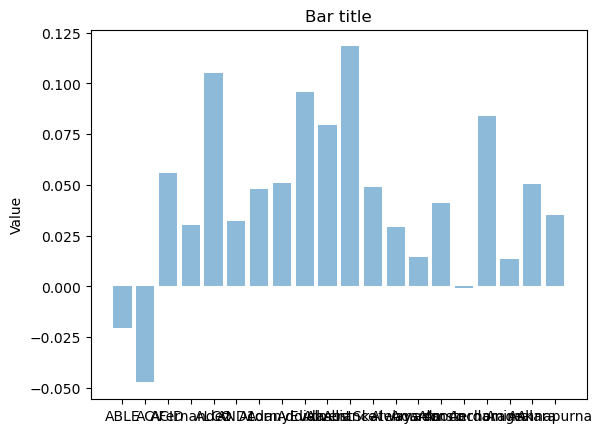

In [26]:
path="D:/Downloads/datasets/mini_logo_good/test1/11/52jpg.jpg"
img=Image.open(path)
tensorImg=transforms(img)
batchImg=torch.unsqueeze(tensorImg,0)
out=net(batchImg)
test=out
out=out.squeeze()
out=out.tolist()
print(out)
print(max(out))
print(out.index(max(out)))
print(logos_list[out.index(max(out))])
print(sum(out))
y_pos = np.arange(len(logos_list))
plt.bar(y_pos, out, align='center', alpha=0.5)
plt.xticks(y_pos, logos_list)
plt.ylabel('Value')
plt.title('Bar title')

plt.show()
# dataset=tv.datasets.ImageFolder(root=path,transform=transforms)
# #print(dataset[0])
# testloader=torch.utils.data.DataLoader(dataset,batch_size=1,shuffle=True)
# for sample in testloader:
#   img,label = sample
#   img=img.to(device)
#   pred=net(img)
  
#   pred=max(pred).tolist()
#   print(pred)
#   print(pred.index(max(pred)))
#   print(max(pred))
#   print(logos_list[ pred.index(max(pred))])

test for test dataset

In [27]:
label=np.zeros(20)
label[0]=1
label=torch.FloatTensor(label)
get_accuracy(pred,label)

AxisError: axis 1 is out of bounds for array of dimension 1

In [ ]:
a=np.zeros(20)
path = 'D:/Downloads/datasets/mini_logo_good/test'
dataset=tv.datasets.ImageFolder(root=path,transform=transforms)
dataloader=torch.utils.data.DataLoader(dataset,batch_size=1,shuffle=True,num_workers=4)
loss_val=0
acc_val=0
for sample in dataloader:
    img,label = sample

    label = label.to(device)
    label = Func.one_hot(label, num_classes=CountOfClasses).float()
        # label=Func.one_hot(label,num_classes=10)
        #label = label.float()
        #label = label.unsqueeze(1)
    img = img.to(device) 
    pred = net (img)
    out=pred.squeeze()
    out=out.tolist()
    a[out.index(max(out))]+=1
    loss = loss_fn(pred, label)
         
    loss_val+=loss.item()
    acc_val += get_accuracy(pred.cpu(), label.cpu())
    
loss_val /= len(dataloader)
acc_val /= len(dataloader)
print("loss=",loss_val ,"accruracy=",acc_val)
print(a)

loss= 3.1914293801455487 accruracy= 0.059447983014861996
[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0. 471.   0.]


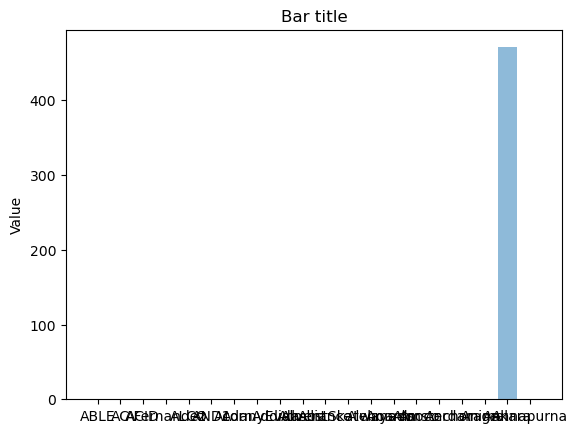

In [ ]:
y_pos = np.arange(len(logos_list))
plt.bar(y_pos, a, align='center', alpha=0.5)
plt.xticks(y_pos, logos_list)
plt.ylabel('Value')
plt.title('Bar title')

plt.show()

эта хуйня не работает